# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Basic pandas and numpy
import pandas as pd
import numpy as np
 
# Basic visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
# Pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
 
# Make jupyter bigger
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious. We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [2]:
websites = pd.read_csv('../data/website.csv')

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

**What the dataset looks like?**

In [3]:
websites.loc[websites.Type == 1].head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,7,0,2,700,9,10,1153,832,9,2.0,1
8,M2_17,20,5,utf-8,nginx/1.10.1,NaN,None,None,8/11/2014 7:41,None,0,0,0,0,2,3,213,146,2,2.0,1
9,M3_75,20,5,utf-8,nginx/1.10.1,NaN,None,None,8/11/2014 7:41,None,0,0,0,0,2,1,62,146,2,2.0,1
15,M0_71,21,7,ISO-8859-1,Apache/2.4.23 (Unix) OpenSSL/1.0.1e-fips mod_b...,957.0,UK,None,16/07/2000 0:00,4/07/2015 0:00,7,0,1,717,11,10,1960,1011,11,4.0,1
16,M0_97,21,7,iso-8859-1,nginx,686.0,RU,Novosibirskaya obl.,25/05/2013 0:00,23/05/2016 0:00,6,0,2,603,8,9,1580,745,8,2.0,1


**What are the data types?**

In [4]:
websites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 21 columns):
URL                          1781 non-null object
URL_LENGTH                   1781 non-null int64
NUMBER_SPECIAL_CHARACTERS    1781 non-null int64
CHARSET                      1781 non-null object
SERVER                       1780 non-null object
CONTENT_LENGTH               969 non-null float64
WHOIS_COUNTRY                1781 non-null object
WHOIS_STATEPRO               1781 non-null object
WHOIS_REGDATE                1781 non-null object
WHOIS_UPDATED_DATE           1781 non-null object
TCP_CONVERSATION_EXCHANGE    1781 non-null int64
DIST_REMOTE_TCP_PORT         1781 non-null int64
REMOTE_IPS                   1781 non-null int64
APP_BYTES                    1781 non-null int64
SOURCE_APP_PACKETS           1781 non-null int64
REMOTE_APP_PACKETS           1781 non-null int64
SOURCE_APP_BYTES             1781 non-null int64
REMOTE_APP_BYTES             1781 non-null int64
APP

* **Numerical variables:** URL_LENGTH, NUMBER_SPECIAL_CHARACTERS, CONTENT_LENGTH, TCP_CONVERSATION_EXCHANGE, DIST_REMOTE_TCP_PORT, REMOTE_IPS, APP_BYTES, REMOTE_APP_PACKETS, SOURCE_APP_BYTES, REMOTE_APP_BYTES, APP_PACKETS, DNS_QUERY_TIMES
* **Categorical variables:** URL, CHARSET, SERVER, WHOIS_COUNTRY, WHOIS_STATEPRO, Type
* **Date-Time variables:** WHOIS_REGDATE, WHOIS_UPDATED_DATE

**Which columns contain the features of the websites?**

URL, URL_LENGTH, SERVER, CONTENT_LENGTH, WHOIS_COUNTRY, WHOIS_STATEPRO, WHOIS_REGDATE, WHOIS_UPDATED_DATE 

**Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?**    

Type. 0 is benign and 1 is malicious.

**Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?**

I don't see any column that should be ordinal yet. I am going to explore the values to see if I can find a pattern

Comments:
* CHARSET: Few values. UTF-8 and utf-8 should be merged as should be ISO-8859-1, iso-8859-1 and ISO-8859
* SERVER: A lot of different values, although many Apache, nginx and Microsoft, with different versions.
* WHOIS_COUNTRY: merge United Kingdom, GB, UK, and [u'GB'; u'UK']. Merge RU and ru. Merge US and us. Find country code for Cyprus. Merge SE and se.
* WHOIS_STATEPRO: Capitalize all.
* WHOIS_REGDATE: to_datetime.
* WHOIS_UPDATED_DATE: to_datetime.

In [5]:
"""
This cell is commented to avoid long file when uploaded to git.
"""
# for column in websites.columns:
    # print(column)
    # print(websites[column].value_counts())
    # print('...................')

'\nThis cell is commented to avoid long file when uploaded to git.\n'

#### Next, evaluate if the columns in this dataset are strongly correlated.

In the Mushroom supervised learning lab we did recently, we mentioned we are concerned if our dataset has strongly correlated columns because if it is the case we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

In [6]:
websites.corr()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.917986,0.129745,-0.038407,-0.039839,-0.046367,-0.026446,-0.042264,-0.033779,-0.014857,-0.026686,-0.042264,-0.068582,0.162104
NUMBER_SPECIAL_CHARACTERS,0.917986,1.000000,0.214225,-0.037459,-0.042619,-0.047103,-0.023914,-0.040096,-0.030597,-0.014376,-0.024098,-0.040096,-0.050048,0.280897
CONTENT_LENGTH,0.129745,0.214225,1.000000,0.078451,-0.000381,0.004774,0.051202,0.074142,0.091077,0.100094,0.047595,0.074142,-0.045644,-0.090852
TCP_CONVERSATION_EXCHANGE,-0.038407,-0.037459,0.078451,1.000000,0.555188,0.331080,0.457320,0.997796,0.990848,0.865580,0.458702,0.997796,0.349832,-0.040202
DIST_REMOTE_TCP_PORT,-0.039839,-0.042619,-0.000381,0.555188,1.000000,0.210188,0.780238,0.558612,0.591188,0.313359,0.781212,0.558612,0.259942,-0.082925
REMOTE_IPS,-0.046367,-0.047103,0.004774,0.331080,0.210188,1.000000,0.023126,0.361104,0.304683,0.171651,0.025324,0.361104,0.548189,-0.078783
APP_BYTES,-0.026446,-0.023914,0.051202,0.457320,0.780238,0.023126,1.000000,0.445822,0.468999,0.074464,0.999992,0.445822,0.012221,-0.011262
SOURCE_APP_PACKETS,-0.042264,-0.040096,0.074142,0.997796,0.558612,0.361104,0.445822,1.000000,0.989285,0.857495,0.447448,1.000000,0.410843,-0.034414
REMOTE_APP_PACKETS,-0.033779,-0.030597,0.091077,0.990848,0.591188,0.304683,0.468999,0.989285,1.000000,0.880555,0.470401,0.989285,0.355716,-0.032897
SOURCE_APP_BYTES,-0.014857,-0.014376,0.100094,0.865580,0.313359,0.171651,0.074464,0.857495,0.880555,1.000000,0.075328,0.857495,0.215285,-0.043852


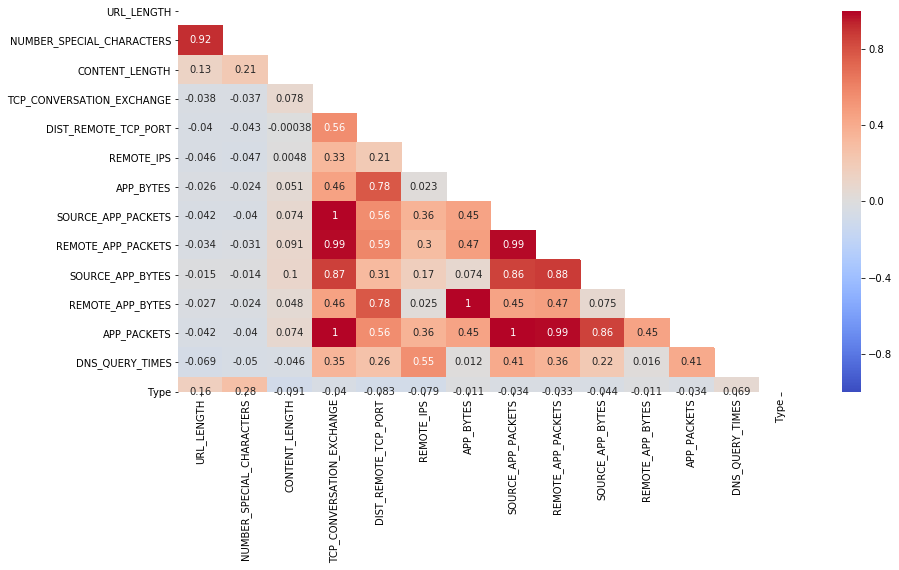

In [7]:
# Set Variables:
cormat = websites.corr()
figsize = (14, 7)
vmin= -1 # Sets maximum color
vmax= 1 # Sets minimum color
cmap = 'coolwarm' # Palette

# Create mask for upper half:
mask = np.zeros_like(cormat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot figure:
plt.figure(figsize=figsize)
sns.heatmap(cormat, 
            vmin=vmin, vmax=vmax, 
            cmap=cmap, 
            annot=True,
            mask= mask)

Columns with high colinearity (> 0.8):
* URL_LENGTH | NUMBER_SPECIAL_CHARACTERS
* SOURCE_APP_PACKETS | TCP_CONVERSATION_EXCHANGE
* REMOTE_APP_PACKETS | TCP_CONVERSATION_EXCHANGE
* SOURCE_APP_BYTES | TCP_CONVERSATION_EXCHANGE
* APP_PACKETS | TCP_CONVERSATION_EXCHANGE
* APP_BYTES | REMOTE_APP_BYTES
* SOURCE_APP_PACKETS | REMOTE_APP_PACKETS
* SOURCE_APP_PACKETS | SOURCE_APP_BYTES
* SOURCE_APP_PACKETS | APP_PACKETS
* REMOTE_APP_PACKETS | SOURCE_APP_BYTES
* REMOTE_APP_PACKETS | APP_PACKETS
* SOURCE_APP_BYTES | APP_PACKETS

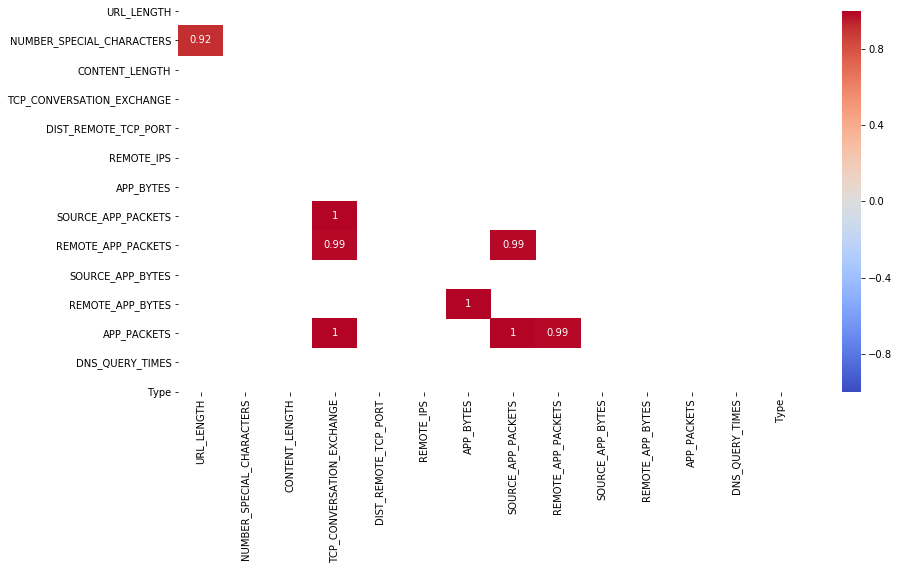

In [8]:
"""Filtering to get only those with correlation > 0.9"""

# Set Variables:
cormat = websites.corr()[websites.corr() >= 0.9]
figsize = (14, 7)
vmin= -1 # Sets maximum color
vmax= 1 # Sets minimum color
cmap = 'coolwarm' # Palette
 
# Create mask for upper half:
mask = np.zeros_like(cormat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Plot figure:
plt.figure(figsize=figsize)
sns.heatmap(cormat,
vmin=vmin, vmax=vmax,
cmap=cmap,
annot=True,
mask= mask)

So I wil be removing NUMBER_SPECIAL_CHARACTERS as well as SOURCE_APP_PACKETS, REMOTE_APP_PACKETS, REMOTE_APP_BYTES and SOURCE_APP_BYTES as they correlate strongly with TCP_CONVERSATION_EXCHANGE

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [9]:
# Removing NUMBER_SPECIAL_CHARACTERS as I think it is not as useful as URL_length
websites.drop('NUMBER_SPECIAL_CHARACTERS', inplace=True, axis=1)

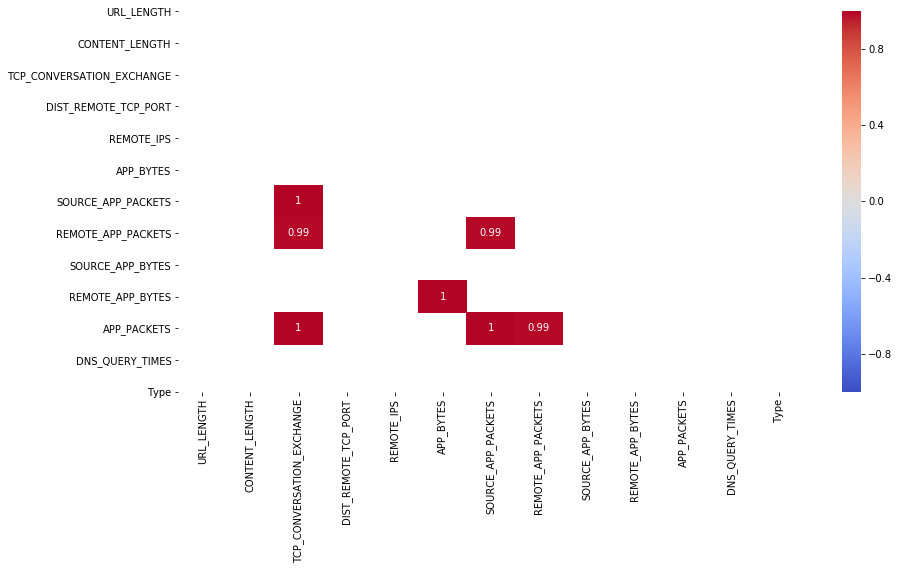

In [10]:
"""Filtering to get only those with correlation > 0.9"""

# Set Variables:
cormat = websites.corr()[websites.corr() >= 0.9]
figsize = (14, 7)
vmin= -1 # Sets maximum color
vmax= 1 # Sets minimum color
cmap = 'coolwarm' # Palette
 
# Create mask for upper half:
mask = np.zeros_like(cormat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Plot figure:
plt.figure(figsize=figsize)
sns.heatmap(cormat,
vmin=vmin, vmax=vmax,
cmap=cmap,
annot=True,
mask= mask)

The high correlation is gone, as we have gotten rid of the column.

In [11]:
# Removing APP_PACKETS:
websites.drop('APP_PACKETS', inplace=True, axis=1)

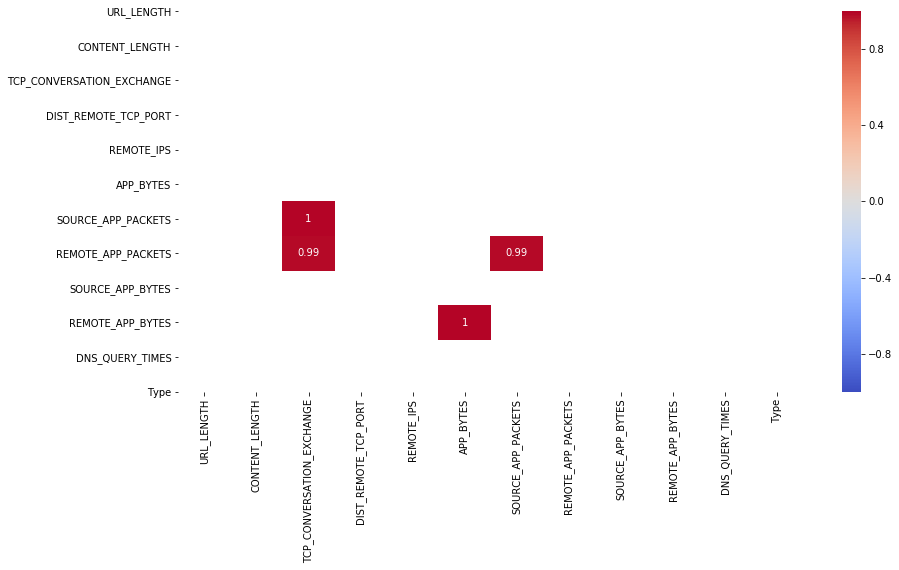

In [12]:
"""Filtering to get only those with correlation > 0.9"""

# Set Variables:
cormat = websites.corr()[websites.corr() >= 0.9]
figsize = (14, 7)
vmin= -1 # Sets maximum color
vmax= 1 # Sets minimum color
cmap = 'coolwarm' # Palette
 
# Create mask for upper half:
mask = np.zeros_like(cormat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Plot figure:
plt.figure(figsize=figsize)
sns.heatmap(cormat,
vmin=vmin, vmax=vmax,
cmap=cmap,
annot=True,
mask= mask)

In [13]:
# Removing SOURCE_APP_PACKETS:
websites.drop('SOURCE_APP_PACKETS', inplace=True, axis=1)

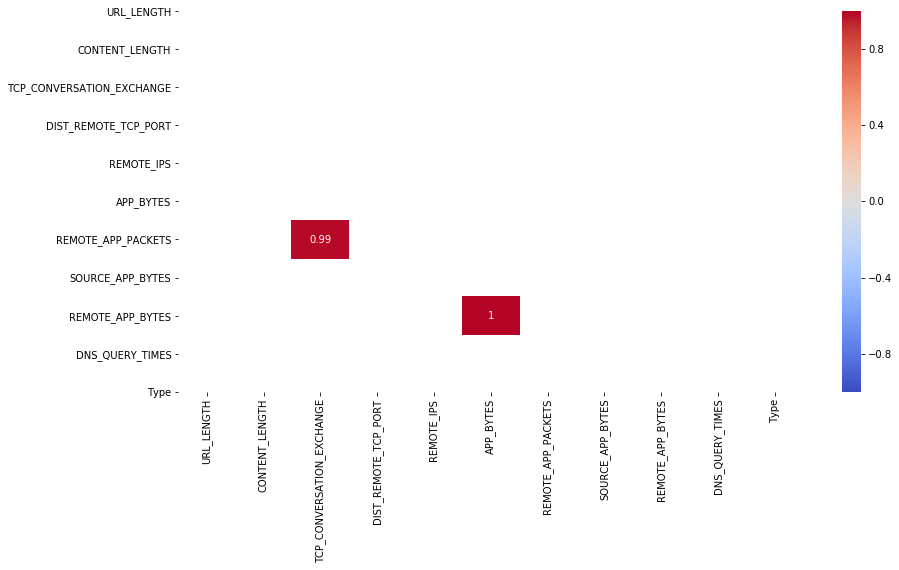

In [14]:
"""Filtering to get only those with correlation > 0.9"""

# Set Variables:
cormat = websites.corr()[websites.corr() >= 0.9]
figsize = (14, 7)
vmin= -1 # Sets maximum color
vmax= 1 # Sets minimum color
cmap = 'coolwarm' # Palette
 
# Create mask for upper half:
mask = np.zeros_like(cormat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Plot figure:
plt.figure(figsize=figsize)
sns.heatmap(cormat,
vmin=vmin, vmax=vmax,
cmap=cmap,
annot=True,
mask= mask)

In [15]:
# Removing REMOTE_APP_PACKETS:
websites.drop('REMOTE_APP_PACKETS', inplace=True, axis=1)

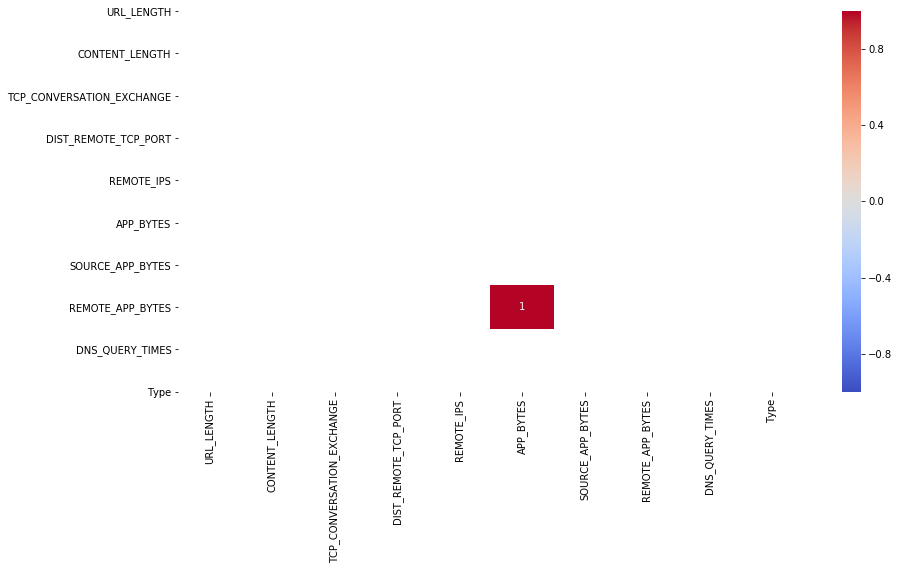

In [16]:
"""Filtering to get only those with correlation > 0.9"""

# Set Variables:
cormat = websites.corr()[websites.corr() >= 0.9]
figsize = (14, 7)
vmin= -1 # Sets maximum color
vmax= 1 # Sets minimum color
cmap = 'coolwarm' # Palette
 
# Create mask for upper half:
mask = np.zeros_like(cormat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Plot figure:
plt.figure(figsize=figsize)
sns.heatmap(cormat,
vmin=vmin, vmax=vmax,
cmap=cmap,
annot=True,
mask= mask)

In [17]:
# Removing REMOTE_APP_BYTES:
websites.drop('REMOTE_APP_BYTES', inplace=True, axis=1)

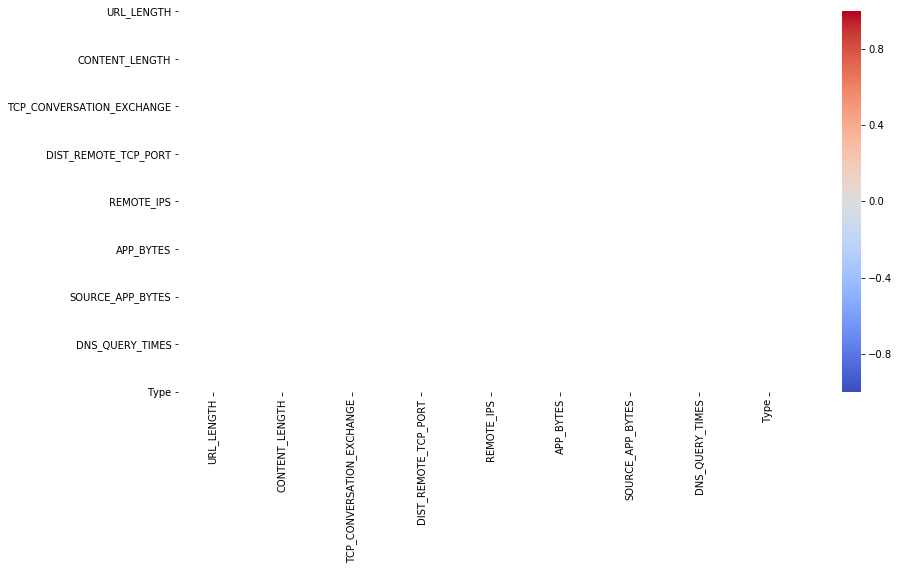

In [18]:
"""Filtering to get only those with correlation > 0.9"""

# Set Variables:
cormat = websites.corr()[websites.corr() >= 0.9]
figsize = (14, 7)
vmin= -1 # Sets maximum color
vmax= 1 # Sets minimum color
cmap = 'coolwarm' # Palette
 
# Create mask for upper half:
mask = np.zeros_like(cormat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Plot figure:
plt.figure(figsize=figsize)
sns.heatmap(cormat,
vmin=vmin, vmax=vmax,
cmap=cmap,
annot=True,
mask= mask)

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [19]:
websites.isna().sum()

URL                            0
URL_LENGTH                     0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                  0
WHOIS_UPDATED_DATE             0
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_BYTES               0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

Although CONTENT_LENGTH would be a useful variable to bear in mind, the number of missing values (about half of the rows) makes it a bit useless. Also, I don't see a way I could impute those nulls, so I decide to drop the column.

In [20]:
websites.drop('CONTENT_LENGTH', axis=1, inplace=True)

I check for the other two nulls

In [21]:
websites.loc[(websites.SERVER.isnull()) | (websites.DNS_QUERY_TIMES.isnull())]

,URL,URL_LENGTH,CHARSET,SERVER,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type
1306,B0_2134,66,UTF-8,NaN,US,District of Columbia,1/02/2003 16:44,2/02/2017 17:11,15,2,4,1026,246,0.0,0
1659,B0_772,101,UTF-8,Apache,CA,ON,14/12/2009 0:00,13/12/2016 0:00,4,2,2,276,416,NaN,0


As they both are part of the non-malicious group (the biggest) and I can't see a way to impute them, I drop them, as I think two observations among more than 1700 will not change the outcome.

In [22]:
websites.drop([1306, 1659], inplace=True)

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [23]:
websites.isna().sum()

URL                          0
URL_LENGTH                   0
CHARSET                      0
SERVER                       0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_BYTES             0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [24]:
websites.WHOIS_COUNTRY.unique()

array(['None', 'US', 'SC', 'GB', 'UK', 'RU', 'AU', 'CA', 'PA', 'se', 'IN',
       'LU', 'TH', "[u'GB'; u'UK']", 'FR', 'NL', 'UG', 'JP', 'CN', 'SE',
       'SI', 'IL', 'ru', 'KY', 'AT', 'CZ', 'PH', 'BE', 'NO', 'TR', 'LV',
       'DE', 'ES', 'BR', 'us', 'KR', 'HK', 'UA', 'CH', 'United Kingdom',
       'BS', 'PK', 'IT', 'Cyprus', 'BY', 'AE', 'IE', 'UY', 'KG'],
      dtype=object)

In [25]:
country_dict = {'Cyprus':'CY', 'us':'US', 'se':'SE', 'GB':'UK', 'United Kingdom':'UK', "[u'GB'; u'UK']":'UK', 'ru':'RU'}

for x,y in country_dict.items():
    websites.WHOIS_COUNTRY.loc[(websites.WHOIS_COUNTRY == x)] = y

/home/eiroamd/.local/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

In [26]:
websites.WHOIS_COUNTRY.value_counts()

US      1105
None     306
CA        83
ES        63
UK        35
AU        35
PA        21
JP        11
IN        10
CN        10
CZ         9
FR         9
CH         6
RU         6
NL         6
KR         5
PH         4
AT         4
BS         4
SE         4
HK         3
SC         3
BE         3
DE         3
TR         3
KY         3
SI         2
BR         2
NO         2
KG         2
IL         2
CY         2
UA         2
UY         2
AE         1
IE         1
PK         1
LU         1
LV         1
IT         1
UG         1
BY         1
TH         1
Name: WHOIS_COUNTRY, dtype: int64

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [27]:
def subs_other(string):
    if string in list(websites.WHOIS_COUNTRY.value_counts()[10:].index):
        return 'OTHER'
    else:
        return string

In [28]:
websites.WHOIS_COUNTRY = websites.WHOIS_COUNTRY.apply(subs_other)

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [29]:
websites.drop(['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'], axis=1, inplace=True)

# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [30]:
websites.dtypes

URL                           object
URL_LENGTH                     int64
CHARSET                       object
SERVER                        object
WHOIS_COUNTRY                 object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_BYTES               int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [31]:
websites.drop('URL', axis=1, inplace=True)

#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [32]:
websites.CHARSET.value_counts()

UTF-8           674
ISO-8859-1      427
utf-8           379
us-ascii        155
iso-8859-1      134
None              7
windows-1251      1
windows-1252      1
ISO-8859          1
Name: CHARSET, dtype: int64

I don't think so...

In [33]:
websites.loc[websites.CHARSET == 'iso-8859-1', 'CHARSET'] = 'ISO-8859-1'

In [34]:
websites.loc[websites.CHARSET == 'ISO-8859', 'CHARSET'] = 'ISO-8859-1'

In [35]:
websites.loc[websites.CHARSET == 'utf-8', 'CHARSET'] = 'UTF-8'

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [36]:
websites.SERVER.value_counts()

Apache                                                                                                                                                                         385
nginx                                                                                                                                                                          211
None                                                                                                                                                                           175
Microsoft-HTTPAPI/2.0                                                                                                                                                          113
cloudflare-nginx                                                                                                                                                                94
Microsoft-IIS/7.5                                                                                        

* SERVER: A lot of different values, although many Apache, nginx and Microsoft, with different versions. I think the column could be simplified or grouped into an 'other' group

![Think Hard](../images/think-hard.jpg)

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [37]:
def server_change(string):
    if 'Microsoft' in string:
        return 'Microsoft'
    elif 'Apache' in string:
        return 'Apache'
    elif 'nginx' in string:
        return 'nginx'
    else:
        return 'Other'

In [38]:
websites.SERVER = websites.SERVER.apply(server_change)

In [39]:
websites.SERVER.value_counts()

Apache       642
Other        504
nginx        435
Microsoft    198
Name: SERVER, dtype: int64

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)).** Make sure you drop the categorical columns by passing `drop_first=True` to `get_dummies` as we don't need them any more. **Also, assign the data with dummy values to a new variable `website_dummy`.**

In [40]:
website_dummy = pd.get_dummies(websites, drop_first=True)

Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [41]:
website_dummy.head()

,URL_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type,CHARSET_None,CHARSET_UTF-8,CHARSET_us-ascii,CHARSET_windows-1251,CHARSET_windows-1252,SERVER_Microsoft,SERVER_Other,SERVER_nginx,WHOIS_COUNTRY_CA,WHOIS_COUNTRY_CN,WHOIS_COUNTRY_ES,WHOIS_COUNTRY_IN,WHOIS_COUNTRY_JP,WHOIS_COUNTRY_None,WHOIS_COUNTRY_OTHER,WHOIS_COUNTRY_PA,WHOIS_COUNTRY_UK,WHOIS_COUNTRY_US
0,16,7,0,2,700,1153,2.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,16,17,7,4,1230,1265,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,16,0,0,0,0,0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,17,31,22,3,3812,18784,8.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,17,57,2,5,4278,129889,4.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [42]:
website_dummy.dtypes

URL_LENGTH                     int64
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_BYTES               int64
DNS_QUERY_TIMES              float64
Type                           int64
CHARSET_None                   uint8
CHARSET_UTF-8                  uint8
CHARSET_us-ascii               uint8
CHARSET_windows-1251           uint8
CHARSET_windows-1252           uint8
SERVER_Microsoft               uint8
SERVER_Other                   uint8
SERVER_nginx                   uint8
WHOIS_COUNTRY_CA               uint8
WHOIS_COUNTRY_CN               uint8
WHOIS_COUNTRY_ES               uint8
WHOIS_COUNTRY_IN               uint8
WHOIS_COUNTRY_JP               uint8
WHOIS_COUNTRY_None             uint8
WHOIS_COUNTRY_OTHER            uint8
WHOIS_COUNTRY_PA               uint8
WHOIS_COUNTRY_UK               uint8
WHOIS_COUNTRY_US               uint8
dtype: object

In [65]:
website_dummy.Type.value_counts(normalize=True)

0    0.878583
1    0.121417
Name: Type, dtype: float64

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [43]:
website_X = website_dummy[[col for col in list(website_dummy.columns.values) if col != 'Type']]
website_y = website_dummy['Type'] 

In [44]:
from sklearn.model_selection import train_test_split

# Your code here:
X_train, X_test, y_train, y_test = train_test_split(website_X, website_y, test_size=0.2, random_state=42)

#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [45]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', max_iter=175)

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [46]:
model = logreg.fit(X_train, y_train)
model

/home/eiroamd/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=175,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[307,   8],
       [ 20,  21]])

In [48]:
f1_score(y_test, y_pred)

0.6000000000000001

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       315
           1       0.72      0.51      0.60        41

    accuracy                           0.92       356
   macro avg       0.83      0.74      0.78       356
weighted avg       0.91      0.92      0.92       356



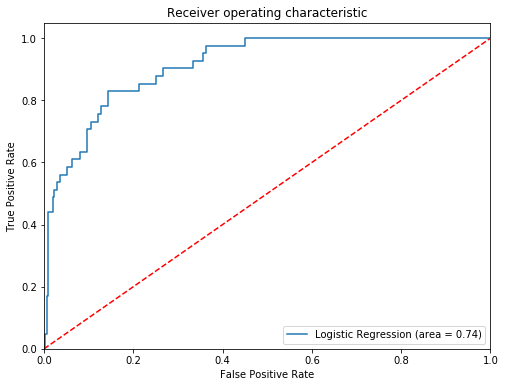

In [51]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

What are your thoughts on the performance of the model? Write your conclusions below.

* Global accuracy of 0.91 so proportion of correct predictions is overall good.
* We can see that the model performs better in terms of precision (positive predictive value) and recall (sensitivity) for the benign websites than for malicious, which may be due to unbalanced data (most of the observations are good websites, not malicious).
* F1-score not really close to 1, so model could perform better.

#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [52]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [53]:
model = knn.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [54]:
confusion_matrix(y_test, y_pred)

array([[307,   8],
       [ 15,  26]])

In [66]:
f1_score(y_test, y_pred)

0.6666666666666666

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       315
           1       0.76      0.63      0.69        41

    accuracy                           0.94       356
   macro avg       0.86      0.80      0.83       356
weighted avg       0.93      0.94      0.93       356



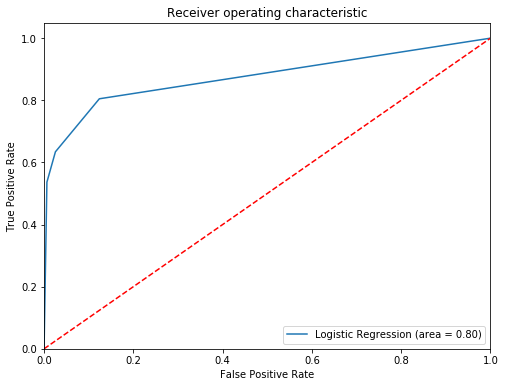

In [58]:
knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

* Confusion matrix similar to logreg.
* Global accuracy of 0.93 so proportion of correct predictions is overall good, an slightly better than logreg.
* We can see that this model still performs better in terms of precision (positive predictive value) and recall (sensitivity) for the benign websites than for malicious, which may be due to unbalanced data (most of the observations are good websites, not malicious).
* F1-score not really close to 1, slightly better than with logreg algorithm.

#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [67]:
knn = KNeighborsClassifier(n_neighbors=5)
model = knn.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [68]:
confusion_matrix(y_test, y_pred)

array([[306,   9],
       [ 16,  25]])

In [69]:
accuracy_score(y_test, y_pred)

0.9297752808988764

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       315
           1       0.74      0.61      0.67        41

    accuracy                           0.93       356
   macro avg       0.84      0.79      0.81       356
weighted avg       0.93      0.93      0.93       356



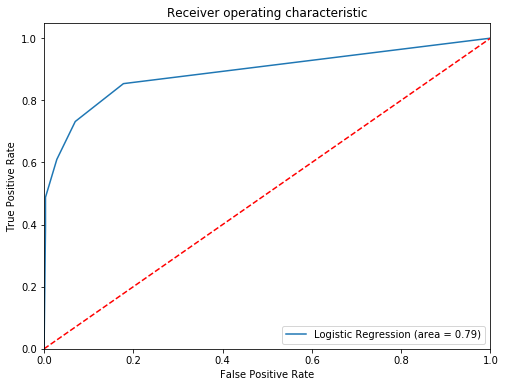

In [63]:
knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

* Global accuracy of 0.93 hasn't changed significantly.
* Precision (positive predictive value) and recall (sensitivity) for the malignant websites have gone down, so it hasn't really been useful to change the k parameter.
* F1-score also worse for 1 (malignant).

# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [71]:
# Your code here